## GGD Case intensity prediction - Part 1 (Model selection)

#### Notebook structure:
1. Import modules
2. Import data
3. Select desired columns and corresponding Dtypes
4. Preprocessing
5. Construct target features
6. Split data
7. Train set balancing
8. Build pipeline
9. Featurization
10. Model selection
11. Saving models

<br>
<div style="text-align: center;">
    <img src='..\visualizations\overleaf_final\DS Pipeline.jpg' width='1200' height='1300'><br>
    <b>Figure 1:</b> Visualization of pipeline
</div>


### 1. Import modules

In [1]:
# Global
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from data_preprocessors.balancer import *
from data_preprocessors.data_preparation import *
from data_preprocessors.data_splitting import *
from data_preprocessors.data_transformation import *
from data_preprocessors.feature_addition import *
from data_preprocessors.target_creation import *

from custom_transformers.custom_transformers import DFFeatureUnion, DFRobustScaler, ColumnExtractor, CountTransformer, DummyTransformer, BooleanTransformer, MultiTransformer, DateTransformer, AgeTransformer

import pandas as pd
import pyodbc
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display='diagram')

# ML
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

# FFNN
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.losses import MeanSquaredLogarithmicError
from sklearn.model_selection import ParameterGrid
from keras.optimizers import Adam

# Model selection
import shap
import joblib
from sklearn.metrics import median_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error, r2_score
from tabulate import tabulate

### 2. Import data

In [2]:
# Load the pickle file into df_og
df_og = pd.read_pickle('..\\..\\Data\\20240502_Regas_Problematiek.pkl')

### 3. Select desired rows, columns and corresponding Dtypes

In [3]:
# Group by 'Casus' and 'Persoonsnummer' and get the last non-null value from each column
df = df_og.groupby(['Casus', 'Persoonsnummer'], as_index=False).last()

# Save column 'casus' as index
df.set_index('Casus', inplace=True)

# Select columns from df_og to work with
df = column_selector(df)

# Map boolean-like values to True's and False's
df = boolean_mapper(df)

# Cast columns to appropriate data types
df = dtype_caster(df)

### 4. Preprocessing

In [4]:
# Convert dates from original df
df['Datum'] = df['Datum'].apply(dates_converter)

# Get the first intervention date globally
min_date = datetime.now().date()
for date_list in df['Datum']:
    if date_list:
        if min(date_list) < min_date:
            min_date = min(date_list)

# Drop every row that has a date of notification before the date of the first intervention ever
df.drop(df[df['Datum_melding'].dt.date < min_date].index, inplace=True)

# Drop all rows with condition 'Onverzekerde zorg GGD GHOR NL'
df.drop(df[df['Vermoeden_van_problematiek'] == 'Onverzekerde zorg GGD GHOR NL'].index, inplace=True)

# Dropping rows where 'Datum_melding' column is empty (there are none so far)
df.dropna(subset=['Datum_melding'], inplace=True)

# Overwrite the column with the transformed version
df['Gemeente'] = df['Gemeente'].apply(municipality_mapper).astype('category')

# Drop rows where 'Gemeente' is 'outside_WB'
df.drop(df[df['Gemeente'] == 'outside_WB'].index, inplace=True)

# Concatenate CBS data on municipality level
df = cbs_concatenator(df)

# Concatenate workload variables of previous 7 days
df = workload_encoder(df, df_og)

### 5. Construct target features

In [5]:
# Add the calculated days to a new column
df['Dagen_tot_laatst'] = df.apply(lambda x: days_extractor(x.Datum_melding, x.Datum), axis=1)

# Add the calculated amount of interventions to a new column
df['No_interventions'] = df['Datum'].apply(interventions_extractor)

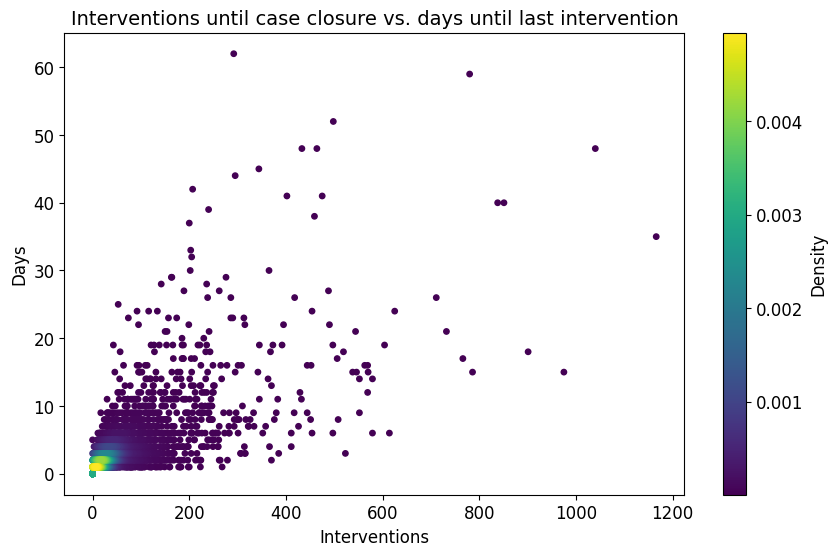

In [6]:
# Define x and y and reset their indices
x = df['Dagen_tot_laatst'].reset_index(drop=True)
y = df['No_interventions'].reset_index(drop=True)

# Calculate the point density
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

# Add labels and title
fig, ax = plt.subplots(figsize=(10, 6))
sc = ax.scatter(x, y, c=z, s=15)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Interventions', fontsize=12)
plt.ylabel('Days', fontsize=12)
plt.title('Interventions until case closure vs. days until last intervention', fontsize=14)

# Add a colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Density', fontsize=12)
cbar.ax.tick_params(labelsize=12)
plt.savefig('../visualizations/overleaf_final/days_interventions.png', bbox_inches='tight', transparent=True)
plt.show()

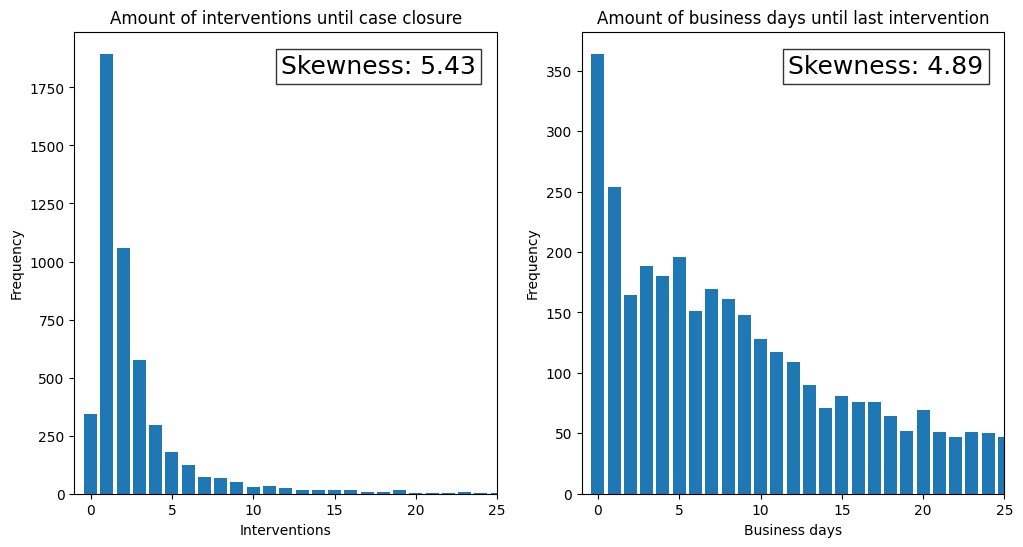

In [8]:
# Visualize skewness of entire dataset
balance_visualizer(df, 'df')

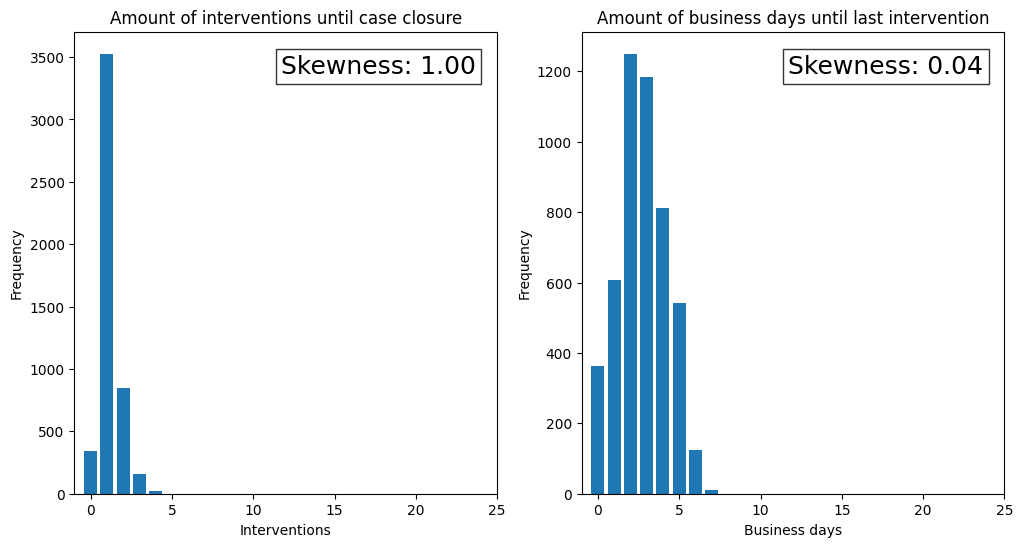

In [9]:
# Apply log1p transformation of df
df_log = df[['Dagen_tot_laatst', 'No_interventions']].applymap(np.log1p)

# Visualize skewness of entire dataset
balance_visualizer_log(df_log, 'df_log')

### 6. Split data

In [20]:
# Split data 4 feature subsets and 4 corresponding target subsets
X_train, y_train, X_val, y_val, X_test, y_test, X_oos, y_oos = data_splitter_v2(df, ['Dagen_tot_laatst', 'No_interventions'])

In [21]:
print_characteristics(X_train, X_val, X_test, X_oos)

+-------+-----------+-----------+--------------------+-----------------+------------------------+------------------------------------+
| Set   | Year(s)   |   # Cases |   # Unclosed cases |   # Unseen ints | % Unseen ints' cases   |   Incoming cases per month per int |
+=======+===========+===========+====================+=================+========================+====================================+
| Train | 2019-2021 |      1978 |                  4 |              26 | 100.00%                |                            2.11325 |
+-------+-----------+-----------+--------------------+-----------------+------------------------+------------------------------------+
| Dev   | 2022      |      1099 |                  9 |               1 | 0.45%                  |                            6.54167 |
+-------+-----------+-----------+--------------------+-----------------+------------------------+------------------------------------+
| Test  | 2023-2024 |      1457 |                138 | 

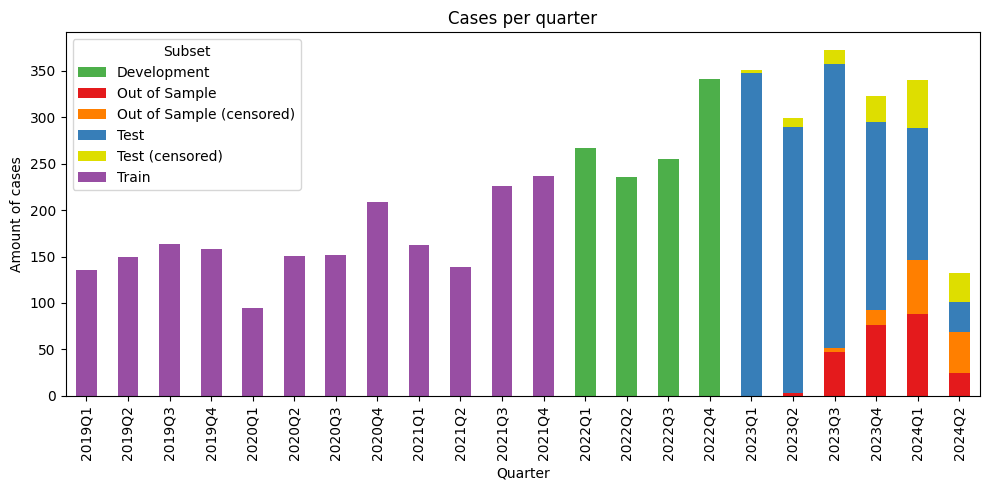

In [22]:
# Add a 'Subset' column to each dataset
X_train = X_train.copy()
X_val = X_val.copy()
X_test = X_test.copy()
X_oos = X_oos.copy()

# Add a 'Subset' column to each dataset
X_train['Subset'] = 'Train'
X_val['Subset'] = 'Development'
X_test['Subset'] = np.where(X_test['Datum_afsluiting'].isna(), 'Test (censored)', 'Test')
X_oos['Subset'] = np.where(X_oos['Datum_afsluiting'].isna(), 'Out of Sample (censored)', 'Out of Sample')

# Append all X sets
X = pd.concat([X_train, X_val, X_test, X_oos], axis=0)

# Convert 'Datum_melding' to datetime if it's not already
X['Datum_melding'] = pd.to_datetime(X['Datum_melding'])

# Extract the quarter from 'Datum_melding'
X['Quarter'] = X['Datum_melding'].dt.to_period('Q')

# Store the amount of cases per quarter and subset
cases_per_quarter = X.groupby(['Quarter', 'Subset']).size().reset_index(name='Count')

# Pivot the data so that each subset is a column
cases_per_quarter_pivot = cases_per_quarter.pivot(index='Quarter', columns='Subset', values='Count').fillna(0)

# Create a stacked bar chart
colors = ['#4daf4a', '#e41a1c', '#ff7f00', '#377eb8', '#dede00', '#984ea3']
cases_per_quarter_pivot.plot(kind='bar', stacked=True, color=colors, figsize=(10, 5))

# Customize the plot (optional)
plt.title("Cases per quarter")
plt.xlabel("Quarter")
plt.ylabel("Amount of cases")

# Set x-tick labels to include the year and quarters
plt.xticks(range(len(cases_per_quarter_pivot)), [str(quarter) for quarter in cases_per_quarter_pivot.index])

# Adjust layout for better appearance
plt.tight_layout()
plt.savefig('..\\..\\Code\\visualizations\\overleaf_final\\cases_per_quarter.png', transparent=True)
plt.show()

#### 6.1. Handle ongoing cases per split

In [23]:
# Drop rows where 'Datum_afsluiting' is empty from the train set, X_train and y_train
X_train.dropna(subset=['Datum_afsluiting'], inplace=True)
indices_train = X_train.index
y_train = y_train.loc[indices_train]

# Drop rows where 'Datum_afsluiting' is empty from the validation set, X_val and y_val
X_val.dropna(subset=['Datum_afsluiting'], inplace=True)
indices_val = X_val.index
y_val = y_val.loc[indices_val]

# Store rows where 'Datum_afsluiting' is empty in new DataFrames
X_test_censored = X_test[X_test['Datum_afsluiting'].isna()]
y_test_censored = y_test.loc[X_test_censored.index]

X_oos_censored = X_oos[X_oos['Datum_afsluiting'].isna()]
y_oos_censored = y_oos.loc[X_oos_censored.index]

# Drop rows where 'Datum_afsluiting' is empty from the test and OoS set
X_test.dropna(subset=['Datum_afsluiting'], inplace=True)
y_test = y_test.loc[X_test.index]

X_oos.dropna(subset=['Datum_afsluiting'], inplace=True)
y_oos = y_oos.loc[X_oos.index]

In [24]:
print_characteristics(X_train, X_val, X_test, X_oos)

+-------+-----------+-----------+--------------------+-----------------+------------------------+------------------------------------+
| Set   | Year(s)   |   # Cases |   # Unclosed cases |   # Unseen ints | % Unseen ints' cases   |   Incoming cases per month per int |
+=======+===========+===========+====================+=================+========================+====================================+
| Train | 2019-2021 |      1974 |                  0 |              26 | 100.00%                |                            2.10897 |
+-------+-----------+-----------+--------------------+-----------------+------------------------+------------------------------------+
| Dev   | 2022      |      1090 |                  0 |               1 | 0.28%                  |                            6.4881  |
+-------+-----------+-----------+--------------------+-----------------+------------------------+------------------------------------+
| Test  | 2023-2024 |      1319 |                  0 | 

### 7. Train set balancing

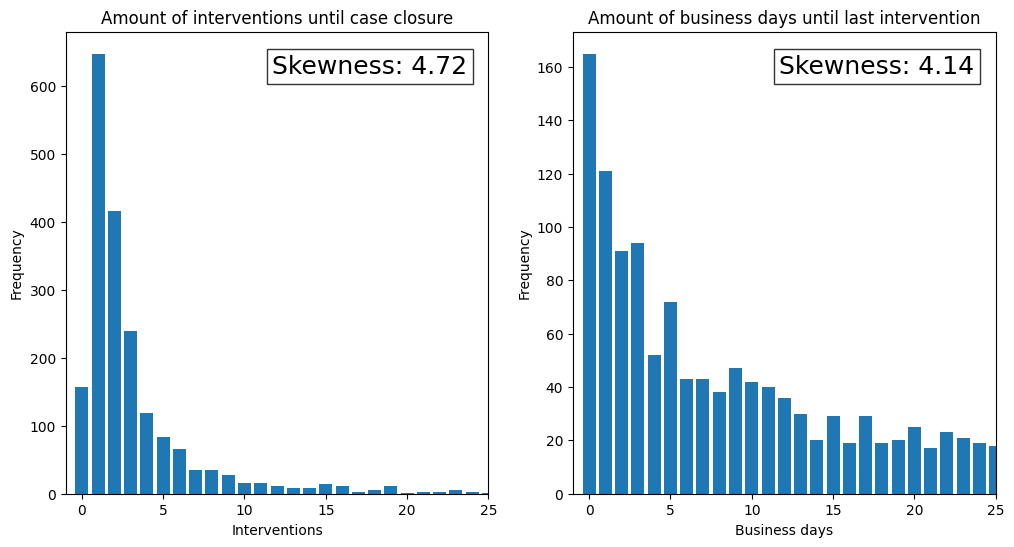

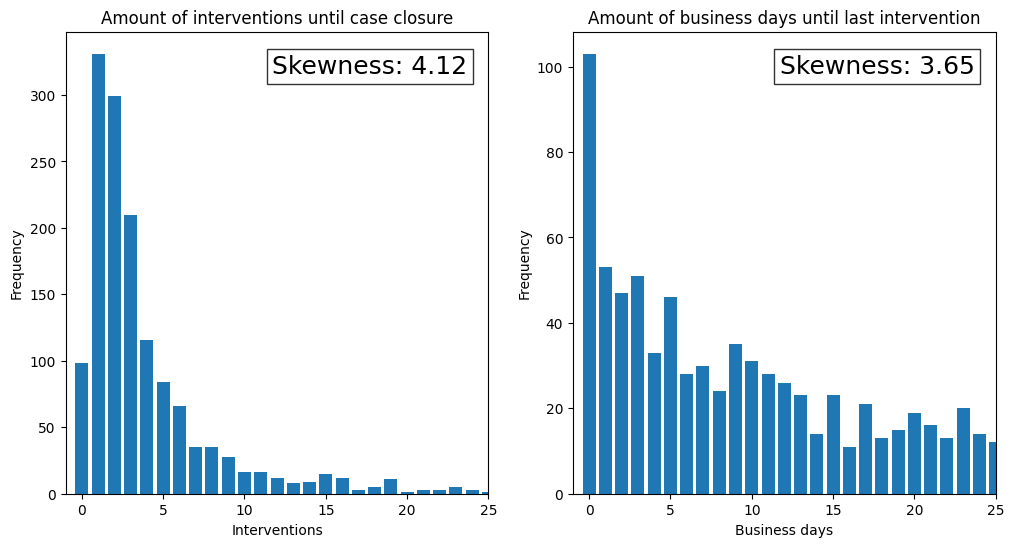

In [26]:
# Visualize skewness pre-balancing
balance_visualizer(y_train, 'train_prebalancing')

# Downsample the heaviest classes (up to param 3 (don't change as there's an open issue in the function)) by a percentage (param 4), 
X_train_balanced, y_train_balanced = balancer(X_train, y_train, 6, 0.5)

# Visualize skewness pre-balancing
balance_visualizer(y_train_balanced, 'train_postbalancing')

In [27]:
print_characteristics(X_train_balanced, X_val, X_test, X_oos)

+-------+-----------+-----------+--------------------+-----------------+------------------------+------------------------------------+
| Set   | Year(s)   |   # Cases |   # Unclosed cases |   # Unseen ints | % Unseen ints' cases   |   Incoming cases per month per int |
+=======+===========+===========+====================+=================+========================+====================================+
| Train | 2019-2021 |      1450 |                  0 |              22 | 100.00%                |                            1.83081 |
+-------+-----------+-----------+--------------------+-----------------+------------------------+------------------------------------+
| Dev   | 2022      |      1090 |                  0 |               2 | 0.46%                  |                            6.4881  |
+-------+-----------+-----------+--------------------+-----------------+------------------------+------------------------------------+
| Test  | 2023-2024 |      1319 |                  0 | 

### 8. Build pipeline

In [28]:
# Group columns by type of preprocessing needed
CAT_FEATS = ['Soort_melder', 'Melding_hoe_ontvangen', 'Eerste_advies', 'Medewerker']
BOOL_FEATS = ['Is_er_sprake_van_huiselijk_geweld?', 'Is_er_sprake_van_agressie_/_geweld?', 'Wijk-GGD', 'DubbelRecord', 'Aanwezigheid_minderjarige_kinderen']
MULTI_FEATS = ['Vermoeden_van_problematiek']
DATE_FEATS = ['Datum_melding']
AGE_FEATS = ['Geboortejaar', 'Datum_melding']
ASIS_FEATS = ['inwoners', 'inwoners_per_km2', 'bevolkingsgroei_per_1000', 'uitkeringsontvangers_per_1000', 'workload_week_interventions_team', 'workload_week_cases_team', 'workload_week_interventions_interventionist', 'workload_week_cases_interventionist', 'workload_ongoing_cases_team', 'workload_ongoing_cases_interventionist']

# Define featurization steps in pipeline
pipeline = Pipeline([
    ('features', DFFeatureUnion([
        ('categoricals', Pipeline([
            ('extract', ColumnExtractor(CAT_FEATS)),
            ('dummy', DummyTransformer())
        ])),
        ('booleans', Pipeline([
            ('extract', ColumnExtractor(BOOL_FEATS)),
            ('booleans', BooleanTransformer())
        ])),
        ('multis', Pipeline([
            ('extract', ColumnExtractor(MULTI_FEATS)),
            ('multis', MultiTransformer())
        ])),
        ('count', Pipeline([
            ('extract', ColumnExtractor(MULTI_FEATS)),
            ('count', CountTransformer())
        ])),
        ('notification_date', Pipeline([
            ('extract', ColumnExtractor(DATE_FEATS)),
            ('date', DateTransformer())
        ])),
        ('age', Pipeline([
            ('extract', ColumnExtractor(AGE_FEATS)),
            ('age', AgeTransformer())
        ])),
        ('additional', Pipeline([
            ('extract', ColumnExtractor(ASIS_FEATS))
        ]))
    ])),
    ('scaler', DFRobustScaler()),
])

# Fit pipeline and featurize train and val
pipeline.fit(X_train_balanced)

Pipeline(steps=[('features',
                 <custom_transformers.custom_transformers.DFFeatureUnion object at 0x0000025C33FE0500>),
                ('scaler',
                 <custom_transformers.custom_transformers.DFRobustScaler object at 0x0000025C33FE12E0>)])

### 9. Featurization

In [32]:
# Store featurized partitions
X_train_balanced_featurized = pipeline.transform(X_train_balanced)
X_train_featurized = pipeline.transform(X_train)
X_val_featurized = pipeline.transform(X_val)
X_test_featurized = pipeline.transform(X_test)
X_oos_featurized = pipeline.transform(X_oos)
X_test_censored_featurized = pipeline.transform(X_test_censored)
X_oos_censored_featurized = pipeline.transform(X_oos_censored)

In [33]:
# Log() transform the target variables and store the transformation in new pandas dataframes
y_train_log = y_train.applymap(np.log1p)
y_train_balanced_log = y_train_balanced.applymap(np.log1p)
y_val_log = y_val.applymap(np.log1p)
y_test_log = y_test.applymap(np.log1p)
y_oos_log = y_oos.applymap(np.log1p)
y_test_censored_log = y_test_censored.applymap(np.log1p)
y_oos_censored_log = y_oos_censored.applymap(np.log1p)

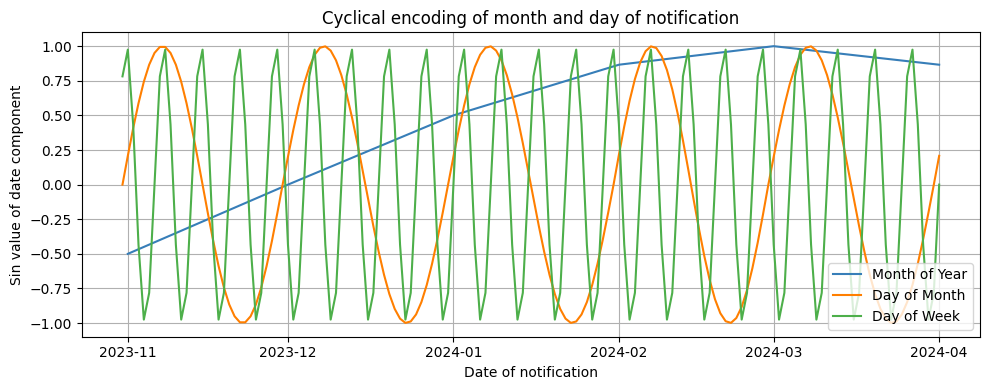

In [34]:
# Store number of points to plot
start_date = pd.Timestamp('2023-10-31')
end_date = pd.Timestamp('2024-4-01')

# Creating hypothetical range of values
dates_months = pd.date_range(start=start_date, end=end_date, freq='MS')
dates_daymonths = pd.date_range(start=start_date, end=end_date, freq='D')
dates_dayweeks = pd.date_range(start=start_date, end=end_date, freq='D')

# Month as a cyclical function of sin
Xmonth = np.sin(2 * np.pi * dates_months.month/12.0)

# Day of month as a cyclical function of sin
Xday_month = np.sin(2 * np.pi * dates_daymonths.day/dates_daymonths.days_in_month)

# Day of week as a cyclical function of sin
Xday_week = np.sin(2 * np.pi * dates_dayweeks.dayofweek/7.0)

# Plotting the cycles
plt.figure(figsize=(10, 4))

# Month
plt.plot(dates_months, Xmonth, color='#377eb8', markersize=4, label='Month of Year')

# Day of month
plt.plot(dates_daymonths, Xday_month, color='#ff7f00', markersize=4, label='Day of Month')

# Day of week
plt.plot(dates_dayweeks, Xday_week, color='#4daf4a', markersize=4, label='Day of Week')

plt.title('Cyclical encoding of month and day of notification')
plt.xlabel('Date of notification')
plt.ylabel('Sin value of date component')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('../visualizations/overleaf_final/cyclical_continuous.png', bbox_inches='tight', transparent=True)
plt.show()

#### 9.1 Save evaluation splits

In [35]:
# Define list of names equal to variable names
split_names = ['X_test_featurized', 'X_oos_featurized', 'X_test_censored_featurized', 'X_oos_censored_featurized', 'y_test_log', 'y_oos_log', 'y_test_censored_log', 'y_oos_censored_log', 'y_test', 'y_oos', 'y_test_censored', 'y_oos_censored']

splits = [X_test_featurized, X_oos_featurized, X_test_censored_featurized, X_oos_censored_featurized, y_test_log, y_oos_log, y_test_censored_log, y_oos_censored_log, y_test, y_oos, y_test_censored, y_oos_censored]

# Save all test and oos sets as separate .pkl files
for split in range(len(splits)):
    splits[split].to_pickle(f'..\\..\\Data\\Splits\\20240502_{split_names[split]}.pkl')


### 10. Model selection

#### 10.1 Undersampled pipeline

##### 10.1.1 Random Forest

In [19]:
# Define the hyperparameters to test
n_estimators_values = [50, 100, 150]
criterion_values = ['squared_error', 'absolute_error']
max_depth_values = [10, 20, 30]

# Initialize lists to store the results
rf_results_undersampled = []

# Loop over the n_estimators values
for n_estimators in n_estimators_values:
    # Loop over the criterion values
    for criterion in criterion_values:
        # Loop over the max_depth values
        for max_depth in max_depth_values:
            # Fit model
            randomforest = RandomForestRegressor(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, random_state=42)
            randomforest.fit(X_train_balanced_featurized, y_train_balanced_log)

            # Get model predictions on validation set
            y_pred_val_rf = randomforest.predict(X_val_featurized)

            # Inverse log() transform the predictions
            y_pred_val_rf = np.expm1(y_pred_val_rf)

            # Calculate validation metrics
            y_pred_val_rf_df = pd.DataFrame(y_pred_val_rf, columns=['Dagen_tot_laatst', 'No_interventions'])

            # Calculate metrics for each output separately and append to the results lists
            result_undersampled = {
                'n_estimators': n_estimators,
                'criterion': criterion,
                'max_depth': str(max_depth),
                'mae_interventions': round(median_absolute_error(y_val['No_interventions'], y_pred_val_rf_df['No_interventions']), 2),
                'mae_days': round(median_absolute_error(y_val['Dagen_tot_laatst'], y_pred_val_rf_df['Dagen_tot_laatst']), 2),
                'mape_interventions': round(mean_absolute_percentage_error(y_val['No_interventions'], y_pred_val_rf_df['No_interventions']), 2),
                'mape_days': round(mean_absolute_percentage_error(y_val['Dagen_tot_laatst'], y_pred_val_rf_df['Dagen_tot_laatst']), 2),
                'mse_interventions': round(mean_squared_error(y_val['No_interventions'], y_pred_val_rf_df['No_interventions']), 2),
                'mse_days': round(mean_squared_error(y_val['Dagen_tot_laatst'], y_pred_val_rf_df['Dagen_tot_laatst']), 2),
                'msle_interventions': round(mean_squared_log_error(y_val['No_interventions'], y_pred_val_rf_df['No_interventions']), 2),
                'msle_days': round(mean_squared_log_error(y_val['Dagen_tot_laatst'], y_pred_val_rf_df['Dagen_tot_laatst']), 2),
                'r2_interventions': round(r2_score(y_val['No_interventions'], y_pred_val_rf_df['No_interventions']), 2),
                'r2_days': round(r2_score(y_val['Dagen_tot_laatst'], y_pred_val_rf_df['Dagen_tot_laatst']), 2)
            }
            rf_results_undersampled.append(result_undersampled)

# Convert the results to a DataFrame for easier viewing
rf_results_undersampled = pd.DataFrame(rf_results_undersampled)

In [20]:
rf_results_undersampled

,n_estimators,criterion,max_depth,mae_interventions,mae_days,mape_interventions,mape_days,mse_interventions,mse_days,msle_interventions,msle_days,r2_interventions,r2_days
0,50,squared_error,10,1.10,13.01,1.141254e+14,1.211790e+15,10.21,3931.22,0.29,1.41,0.10,0.11
1,50,squared_error,20,1.07,12.51,1.124106e+14,1.173928e+15,10.29,3989.71,0.29,1.43,0.09,0.10
2,50,squared_error,30,1.09,12.12,1.103160e+14,1.104564e+15,10.15,3980.87,0.29,1.42,0.10,0.10
3,50,absolute_error,10,1.06,12.98,1.073486e+14,1.289792e+15,10.50,3887.56,0.28,1.44,0.07,0.12
4,50,absolute_error,20,1.06,12.63,1.101616e+14,1.206558e+15,10.21,3949.01,0.28,1.41,0.10,0.11
5,50,absolute_error,30,1.09,13.06,1.087149e+14,1.188497e+15,10.28,3937.69,0.29,1.42,0.09,0.11
6,100,squared_error,10,1.09,13.17,1.110893e+14,1.199802e+15,10.25,3878.46,0.29,1.42,0.10,0.13
7,100,squared_error,20,1.09,12.22,1.095925e+14,1.169206e+15,10.22,3937.14,0.29,1.43,0.10,0.11
8,100,squared_error,30,1.08,12.00,1.081559e+14,1.142791e+15,10.16,3917.37,0.28,1.42,0.10,0.12
9,100,absolute_error,10,1.03,13.07,1.055323e+14,1.318519e+15,10.21,3830.85,0.28,1.43,0.10,0.14


##### 10.1.2 Feed-Forward Neural Network

In [21]:
# Define the hyperparameters to tune
param_grid = {
    'neurons': [16, 32, 64, 128, 256],
    'learning_rate': [0.01, 0.001, 0.0001],
    'epochs': [50, 100, 150]
}

def get_model(n_inputs, n_outputs, neurons1, learning_rate):
    model = Sequential()
    model.add(Dense(neurons1, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss=MeanSquaredLogarithmicError(), optimizer=optimizer)
    return model

# List to store the results
ffnn_results_undersampled = []

# Get the number of inputs and outputs from the dataset
n_inputs, n_outputs = X_train_balanced_featurized.shape[1], y_train_balanced_log.shape[1]

# Loop over each combination of hyperparameters
for params in ParameterGrid(param_grid):
    model = get_model(n_inputs, n_outputs, params['neurons'], params['learning_rate'])
    model.fit(X_train_balanced_featurized, y_train_balanced_log, verbose=0, epochs=params['epochs'])
    y_pred_val_ffnn = model.predict(X_val_featurized)
    y_pred_val_ffnn = np.expm1(y_pred_val_ffnn)
    y_pred_val_ffnn = np.where(y_pred_val_ffnn < 0, 0, y_pred_val_ffnn)
    for i in range(len(y_pred_val_ffnn)):
        if y_pred_val_ffnn[i][1] == 0:
            y_pred_val_ffnn[i] = [0, 0]
        # if i[0] is 'inf' set to max(y_train['Dagen_tot_laatst'])
        if y_pred_val_ffnn[i][0] == float('inf'):
            y_pred_val_ffnn[i][0] = max(y_train['Dagen_tot_laatst'])
        if y_pred_val_ffnn[i][1] == float('inf'):
            y_pred_val_ffnn[i][1] = max(y_train['No_interventions'])
    y_pred_val_ffnn_df = pd.DataFrame(y_pred_val_ffnn, columns=['Dagen_tot_laatst', 'No_interventions'])
    
    # Calculate the evaluation metrics for each target separately
    result_undersampled = {
        'neurons': params['neurons'],
        'learning_rate': params['learning_rate'],
        'epochs': params['epochs'],
        'mae_interventions': round(median_absolute_error(y_val['No_interventions'], y_pred_val_ffnn_df['No_interventions']), 2),
        'mae_days': round(median_absolute_error(y_val['Dagen_tot_laatst'], y_pred_val_ffnn_df['Dagen_tot_laatst']), 2),
        'mape_interventions': round(mean_absolute_percentage_error(y_val['No_interventions'], y_pred_val_ffnn_df['No_interventions']), 2),
        'mape_days': round(mean_absolute_percentage_error(y_val['Dagen_tot_laatst'], y_pred_val_ffnn_df['Dagen_tot_laatst']), 2),
        'mse_interventions': round(mean_squared_error(y_val['No_interventions'], y_pred_val_ffnn_df['No_interventions']), 2),
        'mse_days': round(mean_squared_error(y_val['Dagen_tot_laatst'], y_pred_val_ffnn_df['Dagen_tot_laatst']), 2),
        'msle_interventions': round(mean_squared_log_error(y_val['No_interventions'], y_pred_val_ffnn_df['No_interventions']), 2),
        'msle_days': round(mean_squared_log_error(y_val['Dagen_tot_laatst'], y_pred_val_ffnn_df['Dagen_tot_laatst']), 2),
        'r2_interventions': round(r2_score(y_val['No_interventions'], y_pred_val_ffnn_df['No_interventions']), 2),
        'r2_days': round(r2_score(y_val['Dagen_tot_laatst'], y_pred_val_ffnn_df['Dagen_tot_laatst']), 2)
    }
    
    # Store the results
    ffnn_results_undersampled.append(result_undersampled)

# Convert the results to a DataFrame for easier viewing
ffnn_results_undersampled = pd.DataFrame(ffnn_results_undersampled)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━

In [22]:
ffnn_results_undersampled

,neurons,learning_rate,epochs,mae_interventions,mae_days,mape_interventions,mape_days,mse_interventions,mse_days,msle_interventions,msle_days,r2_interventions,r2_days
0,16,0.0100,50,1.10,18.68,7.998017e+13,1.353924e+15,1.215000e+01,3.360559e+06,0.40,2.40,-7.000000e-02,-7.557600e+02
1,32,0.0100,50,1.21,16.64,1.120087e+14,1.905774e+27,4.742055e+07,1.254323e+62,0.55,7.27,-4.181898e+06,-2.824602e+58
2,64,0.0100,50,1.28,17.09,1.151410e+14,1.113151e+15,2.888000e+01,1.034363e+05,0.50,2.50,-1.550000e+00,-2.229000e+01
3,128,0.0100,50,1.15,15.98,8.140098e+13,1.295763e+15,1.710000e+01,5.887357e+04,0.43,2.40,-5.100000e-01,-1.226000e+01
4,256,0.0100,50,1.79,22.66,4.167031e+14,2.598758e+21,1.320542e+27,1.484227e+50,1.63,6.88,-1.164552e+26,-3.342322e+46
5,16,0.0010,50,0.86,11.36,1.211154e+14,1.261776e+15,1.059000e+01,4.554810e+03,0.29,1.51,7.000000e-02,-3.000000e-02
6,32,0.0010,50,1.21,13.07,1.469239e+14,2.098383e+15,2.894000e+01,2.367193e+04,0.37,1.68,-1.550000e+00,-4.330000e+00
7,64,0.0010,50,1.04,11.44,1.051974e+14,1.208690e+15,1.148000e+01,4.962470e+03,0.34,1.46,-1.000000e-02,-1.200000e-01
8,128,0.0010,50,1.10,14.81,9.157217e+13,1.279226e+15,1.056000e+01,5.425550e+03,0.34,1.73,7.000000e-02,-2.200000e-01
9,256,0.0010,50,1.34,12.71,1.018560e+14,1.204982e+15,1.215000e+01,5.501050e+03,0.40,1.85,-7.000000e-02,-2.400000e-01


##### 10.1.3 Model comparison

In [23]:
# Store all evaluation metric columns in a list
metric_cols = ['mae_interventions', 'mae_days', 'mape_interventions', 'mape_days', 'mse_interventions', 'mse_days', 'msle_interventions', 'msle_days', 'r2_interventions', 'r2_days']

# Create copy to store ranks
rf_ranks = rf_results_undersampled[metric_cols].copy()

# Iterate over each metric and extract the rank
for metric in metric_cols:
    if metric == 'r2_interventions' or metric == 'r2_days':
        rf_ranks[metric] = rf_results_undersampled[metric].sort_values(ascending=False).index
    else:
        rf_ranks[metric] = rf_results_undersampled[metric].sort_values(ascending=True).index

# Make empty dictionary to store all model integers up to and including 17, initialize all to 0
rf_model_ranks = {model: 0 for model in range(len(rf_results_undersampled))}

# For every key in rf_model_ranks, get the lowest rank of the model
for model in rf_model_ranks.keys():
    for metric in metric_cols:
        if rf_ranks.index[rf_ranks[metric] == model][0] > rf_model_ranks[model]:
            rf_model_ranks[model] = rf_ranks.index[rf_ranks[metric] == model][0]

# Get the key of the min value of rf_model_ranks
best_rf_undersampled = min(rf_model_ranks, key=rf_model_ranks.get)

# Print the best model's performance
rf_results_undersampled.iloc[best_rf_undersampled]

n_estimators                             150
criterion                      squared_error
max_depth                                 30
mae_interventions                       1.07
mae_days                               12.29
mape_interventions    107554879900863.578125
mape_days                 1148156977381530.5
mse_interventions                      10.13
mse_days                             3921.76
msle_interventions                      0.28
msle_days                               1.42
r2_interventions                        0.11
r2_days                                 0.12
Name: 14, dtype: object

In [24]:
# Create copy to store ranks
ffnn_ranks = ffnn_results_undersampled[metric_cols].copy()

# Iterate over each metric and extract the rank
for metric in metric_cols:
    if metric == 'r2_interventions' or metric == 'r2_days':
        ffnn_ranks[metric] = ffnn_results_undersampled[metric].sort_values(ascending=False).index
    else:
        ffnn_ranks[metric] = ffnn_results_undersampled[metric].sort_values(ascending=True).index

# Make empty dictionary to store all model integers up to and including 17, initialize all to 0
ffnn_model_ranks = {model: 0 for model in range(len(ffnn_results_undersampled))}

# For every key in rf_model_ranks, get the lowest rank of the model
for model in ffnn_model_ranks.keys():
    for metric in metric_cols:
        if ffnn_ranks.index[ffnn_ranks[metric] == model][0] > ffnn_model_ranks[model]:
            ffnn_model_ranks[model] = ffnn_ranks.index[ffnn_ranks[metric] == model][0]

# Get the key of the min value of rf_model_ranks
best_ffnn_undersampled = min(ffnn_model_ranks, key=ffnn_model_ranks.get)

# Print the best model's performance
ffnn_results_undersampled.iloc[best_ffnn_undersampled]

neurons               3.200000e+01
learning_rate         1.000000e-04
epochs                1.500000e+02
mae_interventions     9.100000e-01
mae_days              1.047000e+01
mape_interventions    1.071161e+14
mape_days             8.826559e+14
mse_interventions     9.940000e+00
mse_days              4.186340e+03
msle_interventions    2.700000e-01
msle_days             1.470000e+00
r2_interventions      1.200000e-01
r2_days               6.000000e-02
Name: 41, dtype: float64

#### 10.2 Regular pipeline

##### 10.2.1 Random Forest

In [25]:
# Define the hyperparameters to test
n_estimators_values = [50, 100, 150]
criterion_values = ['squared_error', 'absolute_error']
max_depth_values = [10, 20, 30]

# Initialize lists to store the results
rf_results_regular = []

# Loop over the n_estimators values
for n_estimators in n_estimators_values:
    # Loop over the criterion values
    for criterion in criterion_values:
        # Loop over the max_depth values
        for max_depth in max_depth_values:
            # Fit model
            randomforest = RandomForestRegressor(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, random_state=42)
            randomforest.fit(X_train_featurized, y_train_log)

            # Get model predictions on validation set
            y_pred_val_rf = randomforest.predict(X_val_featurized)

            # Inverse log() transform the predictions
            y_pred_val_rf = np.expm1(y_pred_val_rf)

            # Calculate validation metrics
            y_pred_val_rf_df = pd.DataFrame(y_pred_val_rf, columns=['Dagen_tot_laatst', 'No_interventions'])

            # Calculate metrics for each output separately and append to the results lists
            result_regular = {
                'n_estimators': n_estimators,
                'criterion': criterion,
                'max_depth': str(max_depth),
                'mae_interventions': round(median_absolute_error(y_val['No_interventions'], y_pred_val_rf_df['No_interventions']), 2),
                'mae_days': round(median_absolute_error(y_val['Dagen_tot_laatst'], y_pred_val_rf_df['Dagen_tot_laatst']), 2),
                'mape_interventions': round(mean_absolute_percentage_error(y_val['No_interventions'], y_pred_val_rf_df['No_interventions']), 2),
                'mape_days': round(mean_absolute_percentage_error(y_val['Dagen_tot_laatst'], y_pred_val_rf_df['Dagen_tot_laatst']), 2),
                'mse_interventions': round(mean_squared_error(y_val['No_interventions'], y_pred_val_rf_df['No_interventions']), 2),
                'mse_days': round(mean_squared_error(y_val['Dagen_tot_laatst'], y_pred_val_rf_df['Dagen_tot_laatst']), 2),
                'msle_interventions': round(mean_squared_log_error(y_val['No_interventions'], y_pred_val_rf_df['No_interventions']), 2),
                'msle_days': round(mean_squared_log_error(y_val['Dagen_tot_laatst'], y_pred_val_rf_df['Dagen_tot_laatst']), 2),
                'r2_interventions': round(r2_score(y_val['No_interventions'], y_pred_val_rf_df['No_interventions']), 2),
                'r2_days': round(r2_score(y_val['Dagen_tot_laatst'], y_pred_val_rf_df['Dagen_tot_laatst']), 2)
            }
            rf_results_regular.append(result_regular)

# Convert the results to a DataFrame for easier viewing
rf_results_regular = pd.DataFrame(rf_results_regular)

In [26]:
rf_results_regular

,n_estimators,criterion,max_depth,mae_interventions,mae_days,mape_interventions,mape_days,mse_interventions,mse_days,msle_interventions,msle_days,r2_interventions,r2_days
0,50,squared_error,10,0.91,10.87,9.735666e+13,9.755588e+14,10.34,3980.94,0.27,1.35,0.09,0.10
1,50,squared_error,20,0.93,11.51,1.011897e+14,9.403693e+14,10.33,3993.06,0.28,1.39,0.09,0.10
2,50,squared_error,30,0.94,11.16,1.016999e+14,9.447662e+14,10.26,3965.08,0.28,1.37,0.10,0.11
3,50,absolute_error,10,0.82,11.05,9.101347e+13,1.098154e+15,10.59,3928.14,0.27,1.37,0.07,0.12
4,50,absolute_error,20,0.90,10.23,9.468746e+13,8.852616e+14,10.21,4007.25,0.27,1.36,0.10,0.10
5,50,absolute_error,30,0.93,10.28,9.471039e+13,9.008203e+14,10.14,3990.70,0.27,1.35,0.11,0.10
6,100,squared_error,10,0.90,11.22,9.765224e+13,9.942441e+14,10.32,3987.86,0.27,1.34,0.09,0.10
7,100,squared_error,20,0.95,11.11,9.861422e+13,9.616978e+14,10.13,3983.41,0.27,1.37,0.11,0.10
8,100,squared_error,30,0.95,11.13,1.007771e+14,9.572256e+14,10.14,3964.84,0.27,1.35,0.11,0.11
9,100,absolute_error,10,0.80,10.89,8.763940e+13,1.043368e+15,10.55,3954.91,0.26,1.36,0.07,0.11


##### 10.2.2 Feed-Forward Neural Network

In [27]:
# Define the hyperparameters to tune
param_grid = {
    'neurons': [16, 32, 64, 128, 256],
    'learning_rate': [0.01, 0.001, 0.0001],
    'epochs': [50, 100, 150]
}

def get_model(n_inputs, n_outputs, neurons1, learning_rate):
    model = Sequential()
    model.add(Dense(neurons1, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss=MeanSquaredLogarithmicError(), optimizer=optimizer)
    return model

# List to store the results
ffnn_results_regular = []

# Get the number of inputs and outputs from the dataset
n_inputs, n_outputs = X_train_featurized.shape[1], y_train_log.shape[1]

# Loop over each combination of hyperparameters
for params in ParameterGrid(param_grid):
    model = get_model(n_inputs, n_outputs, params['neurons'], params['learning_rate'])
    model.fit(X_train_featurized, y_train_log, verbose=0, epochs=params['epochs'])
    y_pred_val_ffnn = model.predict(X_val_featurized)
    y_pred_val_ffnn = np.expm1(y_pred_val_ffnn)
    y_pred_val_ffnn = np.where(y_pred_val_ffnn < 0, 0, y_pred_val_ffnn)
    for i in range(len(y_pred_val_ffnn)):
        if y_pred_val_ffnn[i][1] == 0:
            y_pred_val_ffnn[i] = [0, 0]
        # if i[0] is 'inf' set to max(y_train['Dagen_tot_laatst'])         CHECK TO SEE WHY IT PREDICTS INF
        if y_pred_val_ffnn[i][0] == float('inf'):
            y_pred_val_ffnn[i][0] = max(y_train['Dagen_tot_laatst'])
        if y_pred_val_ffnn[i][1] == float('inf'):
            y_pred_val_ffnn[i][1] = max(y_train['No_interventions'])
    y_pred_val_ffnn_df = pd.DataFrame(y_pred_val_ffnn, columns=['Dagen_tot_laatst', 'No_interventions'])
    
    # Calculate the evaluation metrics for each target separately
    result_regular = {
        'neurons': params['neurons'],
        'learning_rate': params['learning_rate'],
        'epochs': params['epochs'],
        'mae_interventions': round(median_absolute_error(y_val['No_interventions'], y_pred_val_ffnn_df['No_interventions']), 2),
        'mae_days': round(median_absolute_error(y_val['Dagen_tot_laatst'], y_pred_val_ffnn_df['Dagen_tot_laatst']), 2),
        'mape_interventions': round(mean_absolute_percentage_error(y_val['No_interventions'], y_pred_val_ffnn_df['No_interventions']), 2),
        'mape_days': round(mean_absolute_percentage_error(y_val['Dagen_tot_laatst'], y_pred_val_ffnn_df['Dagen_tot_laatst']), 2),
        'mse_interventions': round(mean_squared_error(y_val['No_interventions'], y_pred_val_ffnn_df['No_interventions']), 2),
        'mse_days': round(mean_squared_error(y_val['Dagen_tot_laatst'], y_pred_val_ffnn_df['Dagen_tot_laatst']), 2),
        'msle_interventions': round(mean_squared_log_error(y_val['No_interventions'], y_pred_val_ffnn_df['No_interventions']), 2),
        'msle_days': round(mean_squared_log_error(y_val['Dagen_tot_laatst'], y_pred_val_ffnn_df['Dagen_tot_laatst']), 2),
        'r2_interventions': round(r2_score(y_val['No_interventions'], y_pred_val_ffnn_df['No_interventions']), 2),
        'r2_days': round(r2_score(y_val['Dagen_tot_laatst'], y_pred_val_ffnn_df['Dagen_tot_laatst']), 2)
    }
    
    # Store the results
    ffnn_results_regular.append(result_regular)

# Convert the results to a DataFrame for easier viewing
ffnn_results_regular = pd.DataFrame(ffnn_results_regular)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━

In [28]:
ffnn_results_regular

,neurons,learning_rate,epochs,mae_interventions,mae_days,mape_interventions,mape_days,mse_interventions,mse_days,msle_interventions,msle_days,r2_interventions,r2_days
0,16,0.0100,50,0.90,14.72,7.233581e+13,7.756927e+14,1.199000e+01,7.765988e+05,0.36,2.47,-6.000000e-02,-1.738800e+02
1,32,0.0100,50,1.19,16.51,1.724029e+14,8.426875e+15,2.218000e+01,1.525500e+07,0.48,2.78,-9.600000e-01,-3.434260e+03
2,64,0.0100,50,1.15,15.13,1.789340e+14,3.196994e+15,4.997569e+09,5.167275e+05,0.63,2.95,-4.407230e+08,-1.153600e+02
3,128,0.0100,50,1.08,16.16,1.221894e+14,2.925649e+15,7.728300e+03,1.578549e+08,0.55,2.89,-6.805400e+02,-3.554627e+04
4,256,0.0100,50,1.03,12.94,1.235038e+14,1.807945e+15,3.343000e+01,2.674532e+04,0.43,2.50,-1.950000e+00,-5.020000e+00
5,16,0.0010,50,0.79,11.10,1.057725e+14,1.141782e+15,1.226000e+01,4.204260e+03,0.29,1.50,-8.000000e-02,5.000000e-02
6,32,0.0010,50,0.88,10.85,1.125855e+14,1.475239e+15,3.805000e+01,3.040486e+04,0.33,1.72,-2.360000e+00,-5.850000e+00
7,64,0.0010,50,0.99,10.81,1.066886e+14,1.559543e+15,1.121000e+01,9.707680e+03,0.31,1.78,1.000000e-02,-1.190000e+00
8,128,0.0010,50,1.02,12.41,9.409950e+13,2.045177e+15,1.127000e+01,7.417400e+03,0.35,1.90,1.000000e-02,-6.700000e-01
9,256,0.0010,50,1.00,12.30,7.112257e+13,1.252294e+15,1.185000e+01,2.057154e+04,0.44,2.11,-5.000000e-02,-3.630000e+00


##### 10.2.3 Model comparison

In [29]:
# Store all evaluation metric columns in a list
metric_cols = ['mae_interventions', 'mae_days', 'mape_interventions', 'mape_days', 'mse_interventions', 'mse_days', 'msle_interventions', 'msle_days', 'r2_interventions', 'r2_days']

# Create copy to store ranks
rf_ranks = rf_results_regular[metric_cols].copy()

# Iterate over each metric and extract the rank
for metric in metric_cols:
    if metric == 'r2_interventions' or metric == 'r2_days':
        rf_ranks[metric] = rf_results_regular[metric].sort_values(ascending=False).index
    else:
        rf_ranks[metric] = rf_results_regular[metric].sort_values(ascending=True).index

# Make empty dictionary to store all model integers up to and including 17, initialize all to 0
rf_model_ranks = {model: 0 for model in range(len(rf_results_regular))}

# For every key in rf_model_ranks, get the lowest rank of the model
for model in rf_model_ranks.keys():
    for metric in metric_cols:
        if rf_ranks.index[rf_ranks[metric] == model][0] > rf_model_ranks[model]:
            rf_model_ranks[model] = rf_ranks.index[rf_ranks[metric] == model][0]

# Get the key of the min value of rf_model_ranks
best_rf_regular = min(rf_model_ranks, key=rf_model_ranks.get)

# Print the best model's performance
rf_results_regular.iloc[best_rf_regular]

n_estimators                        150
criterion                absolute_error
max_depth                            20
mae_interventions                  0.91
mae_days                          10.37
mape_interventions     95881485009793.0
mape_days             913232527626152.0
mse_interventions                 10.02
mse_days                        3987.71
msle_interventions                 0.26
msle_days                          1.33
r2_interventions                   0.12
r2_days                             0.1
Name: 16, dtype: object

In [30]:
# Create copy to store ranks
ffnn_ranks = ffnn_results_regular[metric_cols].copy()

# Iterate over each metric and extract the rank
for metric in metric_cols:
    if metric == 'r2_interventions' or metric == 'r2_days':
        ffnn_ranks[metric] = ffnn_results_regular[metric].sort_values(ascending=False).index
    else:
        ffnn_ranks[metric] = ffnn_results_regular[metric].sort_values(ascending=True).index

# Make empty dictionary to store all model integers up to and including 17, initialize all to 0
ffnn_model_ranks = {model: 0 for model in range(len(ffnn_results_regular))}

# For every key in rf_model_ranks, get the lowest rank of the model
for model in ffnn_model_ranks.keys():
    for metric in metric_cols:
        if ffnn_ranks.index[ffnn_ranks[metric] == model][0] > ffnn_model_ranks[model]:
            ffnn_model_ranks[model] = ffnn_ranks.index[ffnn_ranks[metric] == model][0]

# Get the key of the min value of rf_model_ranks
best_ffnn_regular = min(ffnn_model_ranks, key=ffnn_model_ranks.get)

# Print the best model's performance
ffnn_results_regular.iloc[best_ffnn_regular]

neurons               1.600000e+01
learning_rate         1.000000e-04
epochs                1.000000e+02
mae_interventions     7.500000e-01
mae_days              9.950000e+00
mape_interventions    8.584020e+13
mape_days             7.512178e+14
mse_interventions     1.098000e+01
mse_days              4.670260e+03
msle_interventions    2.700000e-01
msle_days             1.480000e+00
r2_interventions      3.000000e-02
r2_days              -5.000000e-02
Name: 25, dtype: float64

### 11. Saving models retrained on train and val sets

In [31]:
# Append X_train_balanced_featurized to X_val_featurized and y_train_balanced_log to y_val_log
X_train_val_balanced_featurized = pd.concat([X_train_balanced_featurized, X_val_featurized], axis=0)
X_train_val_featurized = pd.concat([X_train_featurized, X_val_featurized], axis=0)

y_train_val_balanced_log = pd.concat([y_train_balanced_log, y_val_log], axis=0)
y_train_val_log = pd.concat([y_train_log, y_val_log], axis=0)

y_train_val_balanced = pd.concat([y_train_balanced, y_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

# Define list of names equal to variable names
split_names_y = ['X_train_val_balanced_featurized', 'X_train_val_featurized', 'y_train_val_balanced_log', 'y_train_val_log']
splits_y = [X_train_val_balanced_featurized, X_train_val_featurized, y_train_val_balanced_log, y_train_val_log]

# Save all test and oos sets as separate .pkl files
for split in range(len(splits_y)):
    splits_y[split].to_pickle(f'..\\..\\Data\\Splits\\20240502_{split_names_y[split]}.pkl')

# Fit RF undersampled
randomforest_undersampled = RandomForestRegressor(n_estimators=rf_results_undersampled.iloc[best_rf_undersampled]['n_estimators'],
                                     criterion=rf_results_undersampled.iloc[best_rf_undersampled]['criterion'],
                                     max_depth=int(rf_results_undersampled.iloc[best_rf_undersampled]['max_depth']),
                                     random_state=42)
randomforest_undersampled.fit(X_train_val_balanced_featurized, y_train_val_balanced_log)

# Fit RF regular
randomforest_regular = RandomForestRegressor(n_estimators=rf_results_regular.iloc[best_rf_regular]['n_estimators'],
                                     criterion=rf_results_regular.iloc[best_rf_regular]['criterion'],
                                     max_depth=int(rf_results_regular.iloc[best_rf_regular]['max_depth']),
                                     random_state=42)
randomforest_regular.fit(X_train_val_featurized, y_train_val_log)

# Save random forest as pickle file in the models folder
joblib.dump(randomforest_undersampled, '..\\..\\Model\\best_rf_undersampled.pkl')

# Save random forest as pickle file in the models folder
joblib.dump(randomforest_regular, '..\\..\\Model\\best_rf_regular.pkl')

['..\\..\\Model\\best_rf_regular.pkl']

In [32]:
# Fit model undersampled
neurons = int(ffnn_results_undersampled.iloc[best_ffnn_undersampled]['neurons'])
learning_rate = ffnn_results_undersampled.iloc[best_ffnn_undersampled]['learning_rate']
epochs = int(ffnn_results_undersampled.iloc[best_ffnn_undersampled]['epochs'])

neuralnetwork_undersampled = get_model(n_inputs, n_outputs, neurons, learning_rate)
history = neuralnetwork_undersampled.fit(X_train_val_balanced_featurized, y_train_val_balanced_log, verbose=0, epochs=epochs)

# Fit model
neurons = int(ffnn_results_regular.iloc[best_ffnn_regular]['neurons'])
learning_rate = ffnn_results_regular.iloc[best_ffnn_regular]['learning_rate']
epochs = int(ffnn_results_regular.iloc[best_ffnn_regular]['epochs'])

neuralnetwork_regular = get_model(n_inputs, n_outputs, neurons, learning_rate)
history = neuralnetwork_regular.fit(X_train_val_featurized, y_train_val_log, verbose=0, epochs=epochs)

# Save Keras model in the models folder
neuralnetwork_undersampled.save('..\\..\\Model\\best_ffnn_undersampled.h5')

# Save Keras model in the models folder
neuralnetwork_regular.save('..\\..\\Model\\best_ffnn_regular.h5')